# Over view
テーブルデータの特徴量の意味を理解する  
link:[base notebook](https://www.kaggle.com/chumajin/petfinder-eda-lgbm-for-starter-version)  
感想；  
- Collage,Occlusion,Blurなど、明らかにPawを下げそうな特徴量がある  
- 上に挙げたマイナス特徴量があっても、Paw高い写真もある
 - 予想：人気の犬種は写りが良くてもポイント高いのでは？
- ものによってはミス採点されてるかも
 - 普通に可愛い写真なのに１点だったりする

方針:
- 各特徴量とPawの相関を、統計量使って明らかにする
- 特徴量エンジしてみて、tableデータだけで予測モデル作ってみる
- 画像学習モデルの予測結果と比較して、どういう時に差が出るか調べる
- tabel model と　image model組み合わせてみて、スコア上がらないか試してみる。

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2

# train.csvの中身を見てみる

In [11]:
train = pd.read_csv("../input/petfinder-pawpularity-score/train.csv")
train.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


## 各特徴量の説明

* Id:画像ファイル名,
* Subject Focus:ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることはありません。,
* Eyes:両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔が適切にクリアされています。,
* Face:正面または正面近くを向いた、きちんとクリアな顔。,
* Near:写真のかなりの部分を占める1匹のペット（写真の幅または高さの約50％以上）。,
* Action:アクション（ジャンプなど）の途中でペットを飼う。,
* Accessory:付属の物理的またはデジタルの付属品/支柱（おもちゃ、デジタルステッカーなど）、首輪と鎖を除く。,
* Group:写真に写っているペットが1匹以上。,
* Collage:デジタルレタッチされた写真（つまり、デジタルフォトフレーム、複数の写真の組み合わせ）。,
* Human:写真の中の人間。,
* Occlusion:ペットの一部をブロックする特定の望ましくないオブジェクト（つまり、人間、ケージ、または柵）。すべてのブロッキングオブジェクトがオクルージョンと見なされるわけではないことに注意してください。,
* Info:カスタム追加されたテキストまたはラベル（つまり、ペットの名前、説明）。,
* Blur:特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。ぼかしエントリの場合、「目」列は常に0に設定されます。,
* Pawpularity:ペットの人気(魅力)度


In [3]:
train_path = "../input/petfinder-pawpularity-score/train"

In [4]:
explain_dict ={    
"Id":"画像ファイル名",
"Subject Focus":"ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。",
"Eyes":"両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。",
"Face":"正面または正面近くを向いた、クリアな顔。",
"Near":"写真の幅または高さの約50％以上をペットが占めている。",
"Action":"写真にアクション（ジャンプなど）がある。",
"Accessory":"首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。",
"Group":"写真に写っているペットが1匹以上存在。",
"Collage":"デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。",
"Human":"写真の中に人間が存在する。",
"Occlusion":"ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。",
"Info":"カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。",
"Blur":"特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。",
"Pawpularity":"ペットの人気(魅力)度"
}

In [5]:
train_jap = train.copy()

In [6]:
train_jap.columns = train.columns.map(explain_dict)

In [7]:
train_jap.head(3)

,画像ファイル名,ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。,両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。,正面または正面近くを向いた、クリアな顔。,写真の幅または高さの約50％以上をペットが占めている。,写真にアクション（ジャンプなど）がある。,首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。,写真に写っているペットが1匹以上存在。,デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。,写真の中に人間が存在する。,ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。,カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。,特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。,ペットの人気(魅力)度
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28


In [8]:
tmpdf = train_jap[train_jap.index==0].T
tmpdf

,0
画像ファイル名,0007de18844b0dbbb5e1f607da0606e0
ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。,0
両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。,1
正面または正面近くを向いた、クリアな顔。,1
写真の幅または高さの約50％以上をペットが占めている。,1
写真にアクション（ジャンプなど）がある。,0
首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。,0
写真に写っているペットが1匹以上存在。,1
デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。,0
写真の中に人間が存在する。,0


In [54]:
def showimg(index,feature=None):
    id = index
    if feature:
        id  = list(train[train[feature]==1].index)[index]
    
    plt.figure()
    path = os.path.join(train_path,train["Id"].iloc[id]+".jpg")

    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
    plt.show()

    tmpdf = train_jap[train_jap.index==id].T
    
    print("--------ペットのPawpularity------------")

    print(tmpdf[id].iloc[-1])

    print("--------1の項目------------")

    for a in tmpdf[tmpdf[id]==True].index:
        
        if a == "Pawpularity":
            continue
        
        print("・ " + a)


    print("")



    print("--------0の項目------------")

    for a in tmpdf[tmpdf[id]==False].index:
        
        if a == "Pawpularity":
            continue
        print("・ " + a)



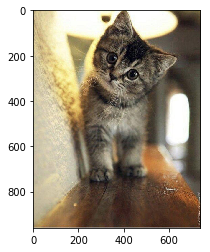

--------ペットのPawpularity------------
95
--------1の項目------------
・ ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。
・ 両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。
・ 正面または正面近くを向いた、クリアな顔。
・ 写真の幅または高さの約50％以上をペットが占めている。

--------0の項目------------
・ 写真にアクション（ジャンプなど）がある。
・ 首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。
・ 写真に写っているペットが1匹以上存在。
・ デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。
・ 写真の中に人間が存在する。
・ ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。
・ カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。
・ 特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。


In [55]:
showimg(0,"Subject Focus")

Eyes,Face,Nearも１
背景が整ってて、ちゃんと動物にフォーカスされているイメージ？  
Focusが１の写真はクオリティ高くてPowも高そう

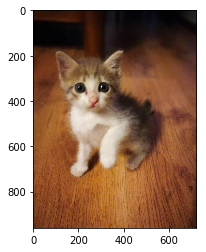

--------ペットのPawpularity------------
55
--------1の項目------------
・ 正面または正面近くを向いた、クリアな顔。
・ 写真の幅または高さの約50％以上をペットが占めている。
・ 写真にアクション（ジャンプなど）がある。
・ 特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。

--------0の項目------------
・ ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。
・ 両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。
・ 首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。
・ 写真に写っているペットが1匹以上存在。
・ デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。
・ 写真の中に人間が存在する。
・ ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。
・ カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。


In [56]:
showimg(0,"Action")

んー、アクションしてるかなこれ、、、笑  
良い写真に見えるけど、Pawは高くない、ボケてるせいか？

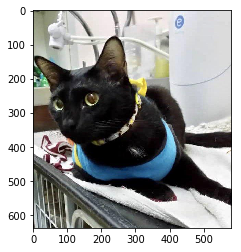

--------ペットのPawpularity------------
13
--------1の項目------------
・ 両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。
・ 首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。

--------0の項目------------
・ ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。
・ 正面または正面近くを向いた、クリアな顔。
・ 写真の幅または高さの約50％以上をペットが占めている。
・ 写真にアクション（ジャンプなど）がある。
・ 写真に写っているペットが1匹以上存在。
・ デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。
・ 写真の中に人間が存在する。
・ ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。
・ カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。
・ 特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。


In [57]:
showimg(0,"Accessory")

どれがアクセサリ判定されたんだろう、後ろの医療機械がマイナスイメージか？

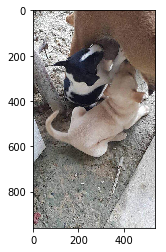

--------ペットのPawpularity------------
72
--------1の項目------------
・ 写真の幅または高さの約50％以上をペットが占めている。
・ 写真に写っているペットが1匹以上存在。

--------0の項目------------
・ ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。
・ 両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。
・ 正面または正面近くを向いた、クリアな顔。
・ 写真にアクション（ジャンプなど）がある。
・ 首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。
・ デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。
・ 写真の中に人間が存在する。
・ ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。
・ カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。
・ 特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。


In [58]:
showimg(1,"Group")

特にコメントなし、おっぱいで加点

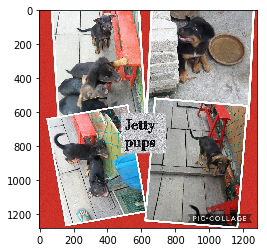

--------ペットのPawpularity------------
35
--------1の項目------------
・ 両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。
・ 正面または正面近くを向いた、クリアな顔。
・ 写真に写っているペットが1匹以上存在。
・ デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。
・ カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。

--------0の項目------------
・ ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。
・ 写真の幅または高さの約50％以上をペットが占めている。
・ 写真にアクション（ジャンプなど）がある。
・ 首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。
・ 写真の中に人間が存在する。
・ ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。
・ 特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。


In [59]:
showimg(0,"Collage")

コラしてる画像、、オシャンやけど、Paw高くはない

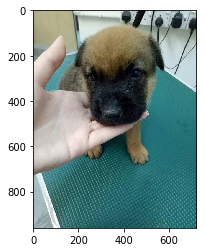

--------ペットのPawpularity------------
28
--------1の項目------------
・ 両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。
・ 正面または正面近くを向いた、クリアな顔。
・ 写真の幅または高さの約50％以上をペットが占めている。
・ 写真の中に人間が存在する。
・ ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。

--------0の項目------------
・ ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。
・ 写真にアクション（ジャンプなど）がある。
・ 首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。
・ 写真に写っているペットが1匹以上存在。
・ デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。
・ カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。
・ 特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。


In [60]:
showimg(0,"Human")

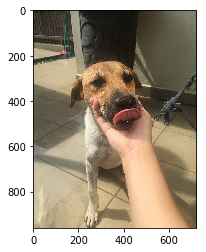

--------ペットのPawpularity------------
22
--------1の項目------------
・ 両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。
・ 正面または正面近くを向いた、クリアな顔。
・ 写真の幅または高さの約50％以上をペットが占めている。
・ 写真の中に人間が存在する。
・ ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。

--------0の項目------------
・ ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。
・ 写真にアクション（ジャンプなど）がある。
・ 首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。
・ 写真に写っているペットが1匹以上存在。
・ デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。
・ カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。
・ 特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。


In [47]:
showimg("Occlusion",1)

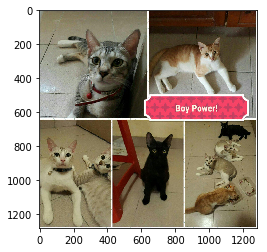

--------ペットのPawpularity------------
25
--------1の項目------------
・ 両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。
・ 正面または正面近くを向いた、クリアな顔。
・ 写真に写っているペットが1匹以上存在。
・ デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。
・ カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。

--------0の項目------------
・ ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。
・ 写真の幅または高さの約50％以上をペットが占めている。
・ 写真にアクション（ジャンプなど）がある。
・ 首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。
・ 写真の中に人間が存在する。
・ ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。
・ 特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。


In [61]:
showimg(3,"Info")

## Pawpularity100を見てみる

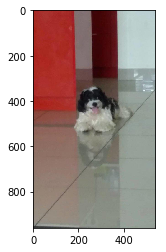

--------ペットのPawpularity------------
74
--------1の項目------------
・ 正面または正面近くを向いた、クリアな顔。
・ 特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。

--------0の項目------------
・ ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。
・ 両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。
・ 写真の幅または高さの約50％以上をペットが占めている。
・ 写真にアクション（ジャンプなど）がある。
・ 首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。
・ 写真に写っているペットが1匹以上存在。
・ デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。
・ 写真の中に人間が存在する。
・ ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。
・ カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。


In [62]:
showimg(0,"Blur")

In [22]:
train[train["Pawpularity"]==100]

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
19,00768659c1c90409f81dcdecbd270513,0,1,1,0,0,0,0,0,0,0,0,0,100
50,013f86ed0e765b189990d3d5ac28bd7d,0,0,0,1,0,0,1,0,0,0,0,0,100
86,0254f54b148543442373d5aad45b2d1a,0,1,1,1,0,0,0,0,0,0,0,0,100
182,04fef9f129bc6e4b90644d4290fde8c3,0,1,1,1,0,0,0,0,0,0,0,0,100
227,063d79b149f4d163eae86f777a39a42f,0,0,1,1,0,0,0,0,0,0,0,1,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9684,fa27d0eeeec835a00853d382f8777b19,0,1,1,1,0,0,0,0,0,0,0,0,100
9725,fb1b85c23f5cc8a079387ff575b67b50,0,1,1,1,0,0,0,0,0,0,1,0,100
9836,fde75ba22f491d31c9267e59f6cbfe1a,0,1,1,1,0,0,0,0,0,0,0,0,100
9843,fe200aff478f55ca4bcf77d9dade1217,0,1,1,1,0,0,0,0,0,0,0,0,100


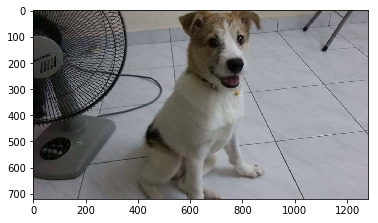

--------ペットのPawpularity------------
100
--------1の項目------------
・ 両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。
・ 正面または正面近くを向いた、クリアな顔。
・ 写真の幅または高さの約50％以上をペットが占めている。

--------0の項目------------
・ ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。
・ 写真にアクション（ジャンプなど）がある。
・ 首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。
・ 写真に写っているペットが1匹以上存在。
・ デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。
・ 写真の中に人間が存在する。
・ ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。
・ カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。
・ 特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。


In [68]:
showimg(86)

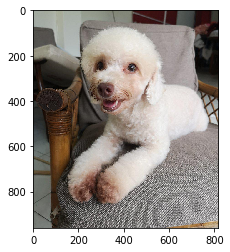

--------ペットのPawpularity------------
100
--------1の項目------------
・ 両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。
・ 正面または正面近くを向いた、クリアな顔。
・ 写真の幅または高さの約50％以上をペットが占めている。

--------0の項目------------
・ ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。
・ 写真にアクション（ジャンプなど）がある。
・ 首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。
・ 写真に写っているペットが1匹以上存在。
・ デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。
・ 写真の中に人間が存在する。
・ ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。
・ カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。
・ 特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。


In [69]:
showimg(182)

## Pawpularity0はないので、1を見てみる

In [25]:
train[train["Pawpularity"]==1]

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
2442,3ed899a8334a8e5c74f4a554f3ce6f08,0,1,1,1,0,0,0,0,0,0,0,0,1
3232,53b536999aecd800cfda720f3ca363cb,0,1,1,1,0,0,0,0,0,0,0,0,1
4235,6c159aede3df25fdbe781431aabcfc67,0,1,1,1,0,0,0,0,0,0,0,0,1
8674,e0a1efdaf4fbed8659b6d23994ee346e,0,1,1,1,0,0,0,0,1,1,0,0,1


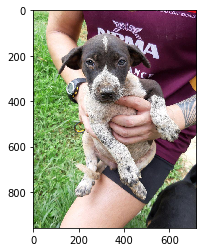

--------ペットのPawpularity------------
1
--------1の項目------------
・ 両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。
・ 正面または正面近くを向いた、クリアな顔。
・ 写真の幅または高さの約50％以上をペットが占めている。
・ 写真の中に人間が存在する。
・ ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。
・ ペットの人気(魅力)度

--------0の項目------------
・ ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。
・ 写真にアクション（ジャンプなど）がある。
・ 首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。
・ 写真に写っているペットが1匹以上存在。
・ デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。
・ カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。
・ 特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。


In [71]:
showimg(8674)

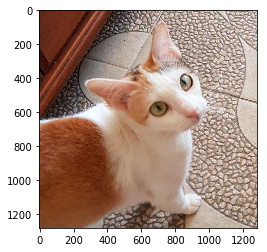

--------ペットのPawpularity------------
1
--------1の項目------------
・ 両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。
・ 正面または正面近くを向いた、クリアな顔。
・ 写真の幅または高さの約50％以上をペットが占めている。
・ ペットの人気(魅力)度

--------0の項目------------
・ ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。
・ 写真にアクション（ジャンプなど）がある。
・ 首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。
・ 写真に写っているペットが1匹以上存在。
・ デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。
・ 写真の中に人間が存在する。
・ ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。
・ カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。
・ 特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。


In [66]:
showimg(3232)

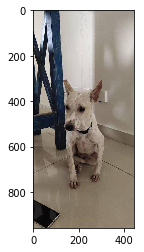

--------ペットのPawpularity------------
1
--------1の項目------------
・ 両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。
・ 正面または正面近くを向いた、クリアな顔。
・ 写真の幅または高さの約50％以上をペットが占めている。
・ ペットの人気(魅力)度

--------0の項目------------
・ ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。
・ 写真にアクション（ジャンプなど）がある。
・ 首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。
・ 写真に写っているペットが1匹以上存在。
・ デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。
・ 写真の中に人間が存在する。
・ ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。
・ カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。
・ 特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。


In [67]:
showimg(4235)

## Pawpularity10ごとに１枚見ていきます。

In [72]:
tmpdf3 = train.groupby("Pawpularity").head(1).sort_values("Pawpularity").reset_index()
tmpdf3

,index,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,2442,3ed899a8334a8e5c74f4a554f3ce6f08,0,1,1,1,0,0,0,0,0,0,0,0,1
1,11,00524dbf2637a80cbc80f70d3ff59616,0,1,1,1,0,0,0,0,0,0,0,0,2
2,125,038dcf0921e7ca7555a5b8e06b5deb29,0,1,1,1,0,0,0,0,0,0,0,0,3
3,111,03061e5075bde4995adf6cbf189b0901,0,1,1,1,0,0,0,0,1,0,0,0,4
4,244,06a6c682c8042ba462bbb4cd2305bcbd,0,1,1,1,0,0,0,0,0,0,0,0,5
5,309,08676b963c016c0044c1140ef1c31a17,0,0,1,1,0,0,0,0,0,0,0,0,6
6,190,053d215699033aa37c5238412eb079d0,0,1,1,1,0,0,0,0,0,0,0,0,7
7,216,05eb59c0af90bc6b419af2a506804537,0,0,1,1,0,0,0,0,0,0,0,0,8
8,286,07cb957b2ff279bbd17c49fe5f8b1d63,0,1,1,1,0,0,0,0,1,1,0,0,9
9,209,05a29b13c5a73d51e882c759916c74d6,0,1,1,1,0,0,0,1,0,1,1,0,10


In [73]:
tmpdf4 = tmpdf3.iloc[::10,:]
tmpdf4

,index,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,2442,3ed899a8334a8e5c74f4a554f3ce6f08,0,1,1,1,0,0,0,0,0,0,0,0,1
10,205,059ce34d757095370e920743b60080b6,0,1,1,1,0,1,0,0,0,0,0,0,11
20,9,0049cb81313c94fa007286e9039af910,0,1,1,1,0,0,0,0,0,0,0,0,21
30,31,00d1cb2ec8b263ae076ff95cae513a88,0,1,1,1,0,0,0,0,0,0,0,0,31
40,13,006483b96ca9c09b7afed3e3d3af539d,0,1,1,1,0,0,0,0,1,1,0,0,41
50,89,02585d6ff78871e7a5eb86ab620bbd0e,0,0,1,1,0,0,0,0,0,0,0,1,51
60,158,047a81a2d5baa5d7526f582fd7bd4805,0,1,1,0,0,0,0,0,0,0,0,0,61
70,164,04a56ab3b8d899eba636bd9b1a4b42dd,0,0,0,1,0,1,1,0,0,0,0,0,71
80,705,12197796395a727f2a6dbbb031c2aeda,0,1,1,1,0,0,0,0,0,0,0,0,81
90,108,02f7bdd5745b91089029fa6826bb2288,0,1,1,1,0,0,0,0,0,0,0,0,91


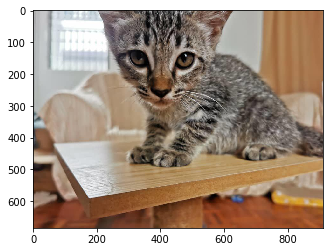

--------ペットのPawpularity------------
1
--------1の項目------------
・ 両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。
・ 正面または正面近くを向いた、クリアな顔。
・ 写真の幅または高さの約50％以上をペットが占めている。
・ ペットの人気(魅力)度

--------0の項目------------
・ ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。
・ 写真にアクション（ジャンプなど）がある。
・ 首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。
・ 写真に写っているペットが1匹以上存在。
・ デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。
・ 写真の中に人間が存在する。
・ ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。
・ カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。
・ 特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。

#################################################


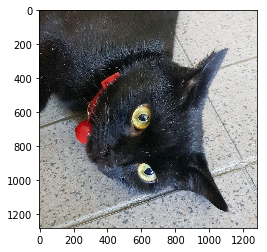

--------ペットのPawpularity------------
11
--------1の項目------------
・ 両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。
・ 正面または正面近くを向いた、クリアな顔。
・ 写真の幅または高さの約50％以上をペットが占めている。
・ 首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。

--------0の項目------------
・ ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。
・ 写真にアクション（ジャンプなど）がある。
・ 写真に写っているペットが1匹以上存在。
・ デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。
・ 写真の中に人間が存在する。
・ ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。
・ カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。
・ 特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。

#################################################


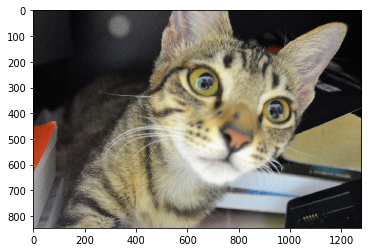

--------ペットのPawpularity------------
21
--------1の項目------------
・ 両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。
・ 正面または正面近くを向いた、クリアな顔。
・ 写真の幅または高さの約50％以上をペットが占めている。

--------0の項目------------
・ ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。
・ 写真にアクション（ジャンプなど）がある。
・ 首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。
・ 写真に写っているペットが1匹以上存在。
・ デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。
・ 写真の中に人間が存在する。
・ ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。
・ カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。
・ 特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。

#################################################


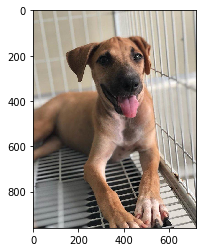

--------ペットのPawpularity------------
31
--------1の項目------------
・ 両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。
・ 正面または正面近くを向いた、クリアな顔。
・ 写真の幅または高さの約50％以上をペットが占めている。

--------0の項目------------
・ ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。
・ 写真にアクション（ジャンプなど）がある。
・ 首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。
・ 写真に写っているペットが1匹以上存在。
・ デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。
・ 写真の中に人間が存在する。
・ ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。
・ カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。
・ 特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。

#################################################


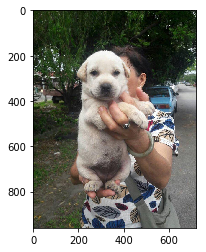

--------ペットのPawpularity------------
41
--------1の項目------------
・ 両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。
・ 正面または正面近くを向いた、クリアな顔。
・ 写真の幅または高さの約50％以上をペットが占めている。
・ 写真の中に人間が存在する。
・ ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。

--------0の項目------------
・ ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。
・ 写真にアクション（ジャンプなど）がある。
・ 首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。
・ 写真に写っているペットが1匹以上存在。
・ デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。
・ カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。
・ 特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。

#################################################


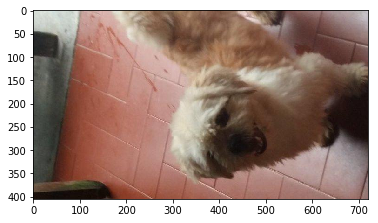

--------ペットのPawpularity------------
51
--------1の項目------------
・ 正面または正面近くを向いた、クリアな顔。
・ 写真の幅または高さの約50％以上をペットが占めている。
・ 特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。

--------0の項目------------
・ ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。
・ 両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。
・ 写真にアクション（ジャンプなど）がある。
・ 首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。
・ 写真に写っているペットが1匹以上存在。
・ デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。
・ 写真の中に人間が存在する。
・ ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。
・ カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。

#################################################


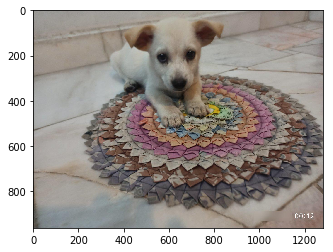

--------ペットのPawpularity------------
61
--------1の項目------------
・ 両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。
・ 正面または正面近くを向いた、クリアな顔。

--------0の項目------------
・ ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。
・ 写真の幅または高さの約50％以上をペットが占めている。
・ 写真にアクション（ジャンプなど）がある。
・ 首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。
・ 写真に写っているペットが1匹以上存在。
・ デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。
・ 写真の中に人間が存在する。
・ ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。
・ カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。
・ 特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。

#################################################


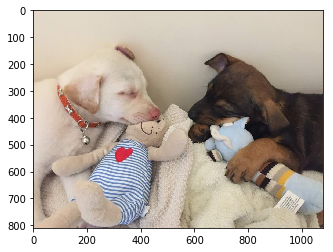

--------ペットのPawpularity------------
71
--------1の項目------------
・ 写真の幅または高さの約50％以上をペットが占めている。
・ 首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。
・ 写真に写っているペットが1匹以上存在。

--------0の項目------------
・ ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。
・ 両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。
・ 正面または正面近くを向いた、クリアな顔。
・ 写真にアクション（ジャンプなど）がある。
・ デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。
・ 写真の中に人間が存在する。
・ ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。
・ カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。
・ 特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。

#################################################


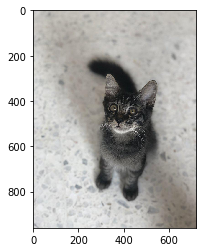

--------ペットのPawpularity------------
81
--------1の項目------------
・ 両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。
・ 正面または正面近くを向いた、クリアな顔。
・ 写真の幅または高さの約50％以上をペットが占めている。

--------0の項目------------
・ ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。
・ 写真にアクション（ジャンプなど）がある。
・ 首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。
・ 写真に写っているペットが1匹以上存在。
・ デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。
・ 写真の中に人間が存在する。
・ ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。
・ カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。
・ 特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。

#################################################


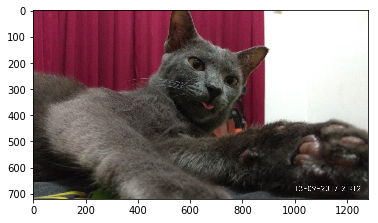

--------ペットのPawpularity------------
91
--------1の項目------------
・ 両方の目が正面または正面近くを向いており、少なくとも1つの目/瞳孔がクリアに写っている。
・ 正面または正面近くを向いた、クリアな顔。
・ 写真の幅または高さの約50％以上をペットが占めている。

--------0の項目------------
・ ペットは整頓された背景に対して際立っており、近すぎたり遠すぎたりすることがない。
・ 写真にアクション（ジャンプなど）がある。
・ 首輪と鎖を除いて、アクセサリが映り込んでいる（おもちゃ、デジタルステッカーなど）。
・ 写真に写っているペットが1匹以上存在。
・ デジタルレタッチされた写真（デジタルフォトフレーム、複数の写真の組み合わせ等）。
・ 写真の中に人間が存在する。
・ ペットの一部を遮っている物体が存在する（人間、ケージ、または柵）。
・ カスタム追加されたテキストまたはラベルが映り込んでいる（ペットの名前、説明）。
・ 特にペットの目や顔の焦点がはっきりしていないか、ノイズが多い。

#################################################


In [74]:
for a in tmpdf4["index"]:
    showimg(a)
    print("")
    print("#################################################")